# Data Quality Analysis — NovaCred Credit Applications

## Purpose
This notebook performs a systematic data quality audit of the `raw_credit_applications.json` dataset. We identify, quantify, and remediate data quality issues across four key dimensions: **Accuracy**, **Completeness**, **Consistency**, and **Validity**.

## Dataset
- **Source:** `../data/raw_credit_applications.json`
- **Context:** Credit application records from NovaCred fintech platform
- **Analysis Date:** February 24, 2026

## Approach
1. Load and flatten nested JSON structure
2. Assess data quality across four dimensions
3. Quantify each issue (counts and percentages)
4. Demonstrate remediation in code
5. Export cleaned dataset for bias analysis

---

## 1. Setup

Import required libraries for data manipulation, analysis, and visualization.

In [32]:
# Data manipulation and analysis
import json
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Utilities
from datetime import datetime
import re

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 50)

print("Libraries loaded successfully")

Libraries loaded successfully


## 2. Data Loading

Load the nested JSON file and flatten the structure using `pd.json_normalize()` to convert nested fields into dot-notation columns.

In [33]:
# Load the JSON file
with open("../data/raw_credit_applications.json", 'r') as f:
    raw_data = json.load(f)

# Flatten nested JSON structure
df_original = pd.json_normalize(raw_data)

# Create working copy for analysis
df = df_original.copy()

print(f"Dataset loaded successfully")
print(f"Original shape: {df.shape[0]} records, {df.shape[1]} columns")
print(f"\nFirst few records:")
df.head()

Dataset loaded successfully
Original shape: 502 records, 21 columns

First few records:


,_id,spending_behavior,processing_timestamp,applicant_info.full_name,applicant_info.email,applicant_info.ssn,applicant_info.ip_address,applicant_info.gender,applicant_info.date_of_birth,applicant_info.zip_code,financials.annual_income,financials.credit_history_months,financials.debt_to_income,financials.savings_balance,decision.loan_approved,decision.rejection_reason,loan_purpose,decision.interest_rate,decision.approved_amount,financials.annual_salary,notes
0,app_200,"[{'category': 'Shopping', 'amount': 480}, {'ca...",2024-01-15T00:00:00Z,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000,23,0.20,31212,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN
1,app_037,"[{'category': 'Rent', 'amount': 608}, {'catego...",NaN,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,M,1992-03-31,10032,78000,51,0.18,17915,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN
2,app_215,"[{'category': 'Rent', 'amount': 109}]",NaN,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000,41,0.21,37909,True,NaN,vacation,3.7,59000.0,NaN,NaN
3,app_024,"[{'category': 'Fitness', 'amount': 575}]",NaN,Thomas Lee,thomas.lee6@protonmail.com,194-35-1833,192.168.175.67,Male,1983-04-25,10077,103000,70,0.35,0,True,NaN,NaN,4.3,34000.0,NaN,NaN
4,app_184,"[{'category': 'Entertainment', 'amount': 463}]",2024-01-15T00:00:00Z,Brian Rodriguez,brian.rodriguez86@aol.com,480-41-2475,172.29.125.105,M,1999-05-21,10080,57000,14,0.23,31763,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN


## 3. Dataset Overview

Examine the structure, data types, and basic statistics of the dataset.

In [34]:
# Display column names and data types
print("Column Names and Data Types:")
print("=" * 80)
df.info()

Column Names and Data Types:
<class 'pandas.DataFrame'>
RangeIndex: 502 entries, 0 to 501
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   _id                               502 non-null    str    
 1   spending_behavior                 502 non-null    object 
 2   processing_timestamp              62 non-null     str    
 3   applicant_info.full_name          502 non-null    str    
 4   applicant_info.email              502 non-null    str    
 5   applicant_info.ssn                497 non-null    str    
 6   applicant_info.ip_address         497 non-null    str    
 7   applicant_info.gender             501 non-null    str    
 8   applicant_info.date_of_birth      501 non-null    str    
 9   applicant_info.zip_code           501 non-null    str    
 10  financials.annual_income          497 non-null    object 
 11  financials.credit_history_months  502 non-null    int

---

## 4. COMPLETENESS Analysis

**Quality Dimension:** Completeness  
**Definition:** Are all required data present?

### 4.1 Missing Values Detection

We check for missing values (nulls, NaN, empty strings) across all columns and quantify the impact.

In [35]:
# Calculate missing values per column
total_records = len(df)

missing_summary = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum().values,
    'Missing_Percentage': (df.isnull().sum().values / total_records * 100).round(2)
})

# Filter to show only columns with missing values
missing_summary = missing_summary[missing_summary['Missing_Count'] > 0].sort_values(
    'Missing_Count', ascending=False
).reset_index(drop=True)

print(f"Missing Values Analysis")
print(f"=" * 80)
print(f"Total records: {total_records}")
print(f"Columns with missing values: {len(missing_summary)} out of {len(df.columns)}")
print(f"\nDetailed Missing Values Report:")
print(missing_summary.to_string(index=False))

Missing Values Analysis
Total records: 502
Columns with missing values: 13 out of 21

Detailed Missing Values Report:
                      Column  Missing_Count  Missing_Percentage
                       notes            500               99.60
    financials.annual_salary            497               99.00
                loan_purpose            452               90.04
        processing_timestamp            440               87.65
   decision.rejection_reason            292               58.17
      decision.interest_rate            210               41.83
    decision.approved_amount            210               41.83
          applicant_info.ssn              5                1.00
   applicant_info.ip_address              5                1.00
    financials.annual_income              5                1.00
       applicant_info.gender              1                0.20
applicant_info.date_of_birth              1                0.20
     applicant_info.zip_code              1       

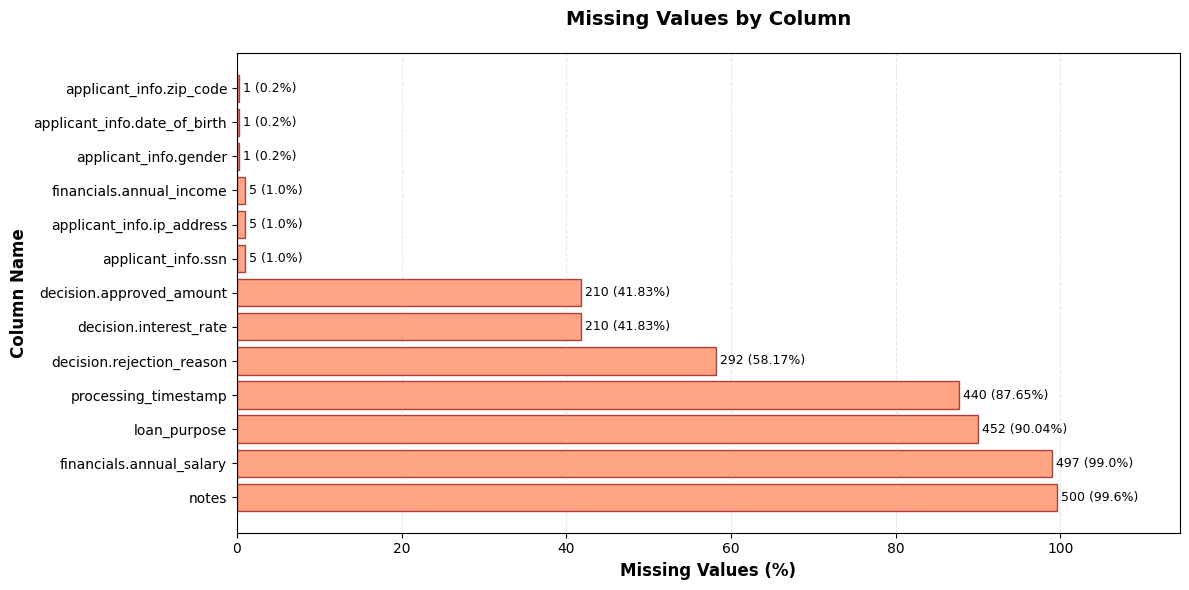

In [36]:
# Visualize missing data
if len(missing_summary) > 0:
    plt.figure(figsize=(12, max(6, len(missing_summary) * 0.4)))
    
    # Create bar chart
    bars = plt.barh(missing_summary['Column'], missing_summary['Missing_Percentage'], 
                    color='coral', edgecolor='darkred', alpha=0.7)
    
    # Add percentage labels on bars
    for i, (count, pct) in enumerate(zip(missing_summary['Missing_Count'], 
                                         missing_summary['Missing_Percentage'])):
        plt.text(pct + 0.5, i, f'{int(count)} ({pct}%)', 
                va='center', fontsize=9)
    
    plt.xlabel('Missing Values (%)', fontsize=12, fontweight='bold')
    plt.ylabel('Column Name', fontsize=12, fontweight='bold')
    plt.title('Missing Values by Column', fontsize=14, fontweight='bold', pad=20)
    plt.xlim(0, max(missing_summary['Missing_Percentage']) * 1.15)
    plt.grid(axis='x', alpha=0.3, linestyle='--')
    plt.tight_layout()
    plt.show()
else:
    print("No missing values detected in the dataset.")

### 4.2 Missing Value Standardization

Before analyzing incomplete records, standardize all missing value representations to NaN for consistency. This includes empty strings, whitespace, and common missing value indicators.

In [37]:

# Standardize missing values across all columns
print("Missing Value Standardization")
print("=" * 80)

# Define common missing value representations
missing_indicators = ['', ' ', 'NA', 'N/A', 'na', 'n/a', 'NaN', 'nan', 'NULL', 'null', 
                     'None', 'none', '-', '--', '?', 'unknown', 'Unknown', 'UNKNOWN']

# Count current missing values before standardization
missing_before = df.isnull().sum().sum()

# Replace missing indicators with NaN
df.replace(missing_indicators, np.nan, inplace=True)

# Also replace empty strings and whitespace-only strings in object/string columns
for col in df.select_dtypes(include=['object','string']).columns:
    # Replace strings that are only whitespace with NaN
    df[col] = df[col].apply(lambda x: np.nan if isinstance(x, str) and x.strip() == '' else x)

# Count missing values after standardization
missing_after = df.isnull().sum().sum()
newly_identified = missing_after - missing_before

print(f"Missing values before standardization: {missing_before}")
print(f"Missing values after standardization:  {missing_after}")
print(f"Newly identified missing values:       {newly_identified}")

if newly_identified > 0:
    newly_identified_pct = round(newly_identified / (total_records * len(df.columns)) * 100, 2)
    print(f"\n**Result:** {newly_identified} additional missing values identified ({newly_identified_pct}% of all data points)")
    print(f"All missing values are now consistently represented as NaN for downstream analysis.")
else:
    print(f"\n**Result:** No additional missing values found. Dataset already uses consistent NaN representation.")


Missing Value Standardization
Missing values before standardization: 2619
Missing values after standardization:  2633
Newly identified missing values:       14

**Result:** 14 additional missing values identified (0.13% of all data points)
All missing values are now consistently represented as NaN for downstream analysis.


### 4.3 Incomplete Records Analysis

Identify how many records have at least one missing value across any field.

In [38]:
# Check for records with ANY missing value
incomplete_records = df[df.isnull().any(axis=1)]
incomplete_count = len(incomplete_records)
incomplete_pct = round(incomplete_count / total_records * 100, 2)

print(f"Incomplete Records Analysis")
print(f"=" * 80)
print(f"Records with at least one missing value: {incomplete_count} ({incomplete_pct}% of dataset)")
print(f"Complete records: {total_records - incomplete_count} ({(100 - incomplete_pct):.2f}% of dataset)")

if incomplete_count > 0:
    print(f"\nSample of incomplete records:")
    # Show which fields are missing in sample records
    sample_incomplete = incomplete_records.head(3)
    for idx, row in sample_incomplete.iterrows():
        missing_fields = row[row.isnull()].index.tolist()
        print(f"\n  Record {row.get('_id', idx)}: Missing {len(missing_fields)} field(s)")
        print(f"    Fields: {', '.join(missing_fields[:5])}", end='')
        if len(missing_fields) > 5:
            print(f" ... and {len(missing_fields) - 5} more")
        else:
            print()


Incomplete Records Analysis
Records with at least one missing value: 502 (100.0% of dataset)
Complete records: 0 (0.00% of dataset)

Sample of incomplete records:

  Record app_200: Missing 5 field(s)
    Fields: loan_purpose, decision.interest_rate, decision.approved_amount, financials.annual_salary, notes

  Record app_037: Missing 6 field(s)
    Fields: processing_timestamp, loan_purpose, decision.interest_rate, decision.approved_amount, financials.annual_salary ... and 1 more

  Record app_215: Missing 4 field(s)
    Fields: processing_timestamp, decision.rejection_reason, financials.annual_salary, notes


### 4.4 Critical Field Missingness

Identify missing values in fields essential for credit decision-making. Critical fields include income, credit score, and decision outcome.

These critical_fields are considered critical because they represent the core inputs and outputs of the loan decision process. On the decision side, `loan_approved`, `interest_rate`, `approved_amount`, and `rejection_reason` capture the actual outcome and terms offered to each applicant, making them essential for auditing fairness and transparency. On the financials side, `annual_income` and `debt_to_income` are the primary creditworthiness indicators, meaning missing or corrupted values in these fields would directly compromise the integrity of any bias or data quality analysis.

In [39]:
critical_fields = ['decision.rejection_reason', 'decision.interest_rate', 'decision.approved_amount', 'financials.annual_income', 'decision.loan_approved', 'financials.debt_to_income']

# Define fields that are only applicable for approved loans
conditional_fields = ['decision.interest_rate', 'decision.approved_amount', 'decision.rejection_reason']

# Split critical fields into always-required vs conditional
always_critical = []
approval_conditional = []

for field in critical_fields:
    if any(pattern in field.lower() for pattern in conditional_fields):
        approval_conditional.append(field)
    else:
        always_critical.append(field)

# Get approved loans count for conditional fields
approved_mask = df['decision.loan_approved'] == True  # adjust to your actual column/value
approved_count = approved_mask.sum()

print(f"Critical Fields Analysis")
print(f"=" * 80)

# Show always-required fields normally
if always_critical:
    critical_missing = pd.DataFrame({
        'Critical_Field': always_critical,
        'Missing_Count': [df[field].isnull().sum() for field in always_critical],
        'Missing_Percentage': [(df[field].isnull().sum() / total_records * 100).round(2)
                               for field in always_critical]
    }).sort_values('Missing_Count', ascending=False)
    print("\nAlways-Required Fields:")
    print(critical_missing.to_string(index=False))

# Show conditional fields relative to approved loans only
if approval_conditional:
    conditional_missing = pd.DataFrame({
        'Conditional_Field': approval_conditional,
        'Missing_Count (approved only)': [df.loc[approved_mask, field].isnull().sum() for field in approval_conditional],
        'Missing_Percentage (approved only)': [(df.loc[approved_mask, field].isnull().sum() / approved_count * 100).round(2)
                                                for field in approval_conditional]
    }).sort_values('Missing_Count (approved only)', ascending=False)
    print(f"\nApproval-Conditional Fields (evaluated against {approved_count} approved loans only):")
    print(conditional_missing.to_string(index=False))

# Only flag records as critically incomplete based on always-required fields
if always_critical:
    records_missing_critical = df[df[always_critical].isnull().any(axis=1)]
    critical_incomplete_count = len(records_missing_critical)
    critical_incomplete_pct = round(critical_incomplete_count / total_records * 100, 2)
    print(f"\n**Impact:** {critical_incomplete_count} records ({critical_incomplete_pct}%) "
          f"are missing at least one always-required critical field.")

Critical Fields Analysis

Always-Required Fields:
           Critical_Field  Missing_Count  Missing_Percentage
 financials.annual_income              5                 1.0
   decision.loan_approved              0                 0.0
financials.debt_to_income              0                 0.0

Approval-Conditional Fields (evaluated against 292 approved loans only):
        Conditional_Field  Missing_Count (approved only)  Missing_Percentage (approved only)
decision.rejection_reason                            292                               100.0
   decision.interest_rate                              0                                 0.0
 decision.approved_amount                              0                                 0.0

**Impact:** 5 records (1.0%) are missing at least one always-required critical field.


### 4.5 Completeness Remediation Strategy

**Approach:**
- Records missing critical decision fields (income, credit score, loan decision) should be flagged for review or removed
- Records missing non-critical fields can be retained with missing values documented
- Track the impact of remediation on dataset size

In [40]:
# Store original count for comparison
records_before_remediation = len(df)

# Identify truly critical fields that must be present for ALL records
# Note: Some fields like rejection_reason are conditional (only for rejected loans)
absolutely_critical = []

# Check for decision/approval field - should be present for all
decision_fields = [col for col in df.columns if 'loan_approved' in col.lower()]
if decision_fields:
    absolutely_critical.extend(decision_fields)

# Check for income field - should be present for all
income_fields = [col for col in df.columns if 'annual_income' in col.lower() or 
                 ('income' in col.lower() and 'financials' in col.lower() and 'debt' not in col.lower())]
if income_fields:
    absolutely_critical.extend(income_fields[:1])  # Take first match

print(f"Remediation Analysis")
print(f"=" * 80)
print(f"Records before remediation: {records_before_remediation}")

if absolutely_critical:
    print(f"\nAbsolutely critical fields (must be present for all records): {absolutely_critical}")
    
    # Flag records missing critical fields
    df['completeness_flag'] = 'complete'
    
    for field in absolutely_critical:
        if field in df.columns:
            missing_mask = df[field].isnull()
            df.loc[missing_mask, 'completeness_flag'] = 'missing_critical_field'
    
    flagged_count = (df['completeness_flag'] == 'missing_critical_field').sum()
    
    print(f"\nRecords flagged for review (missing critical fields): {flagged_count}")
    print(f"Records suitable for analysis: {records_before_remediation - flagged_count}")
    
    if flagged_count > 0:
        flagged_pct = round(flagged_count/records_before_remediation*100, 2)
        print(f"\n**Recommendation:** Consider removing {flagged_count} flagged records before bias analysis.")
        print(f"This would reduce dataset size by {flagged_pct}%")
    else:
        print(f"\n**Result:** All records have complete critical fields for decision-making.")
        print(f"Note: Some fields like 'rejection_reason' and 'interest_rate' are conditionally")
        print(f"present (only for rejected/approved loans respectively) - this is expected.")
else:
    print("\nNote: Unable to automatically identify critical fields from column names.")
    print("Manual review of data structure recommended.")
    print(f"\nAll columns in dataset:")
    for i, col in enumerate(df.columns, 1):
        print(f"  {i}. {col}")

Remediation Analysis
Records before remediation: 502

Absolutely critical fields (must be present for all records): ['decision.loan_approved', 'financials.annual_income']

Records flagged for review (missing critical fields): 5
Records suitable for analysis: 497

**Recommendation:** Consider removing 5 flagged records before bias analysis.
This would reduce dataset size by 1.0%


### 4.6 Completeness Summary

**Quality Dimension:** Completeness  
**Impact:** Missing data reduces the usable dataset size and can introduce bias if missing values are not random.

**Key Findings:**
- Missing values have been standardized to NaN for consistency
- Missing values have been identified and quantified across all fields
- Critical fields essential for credit decisions have been highlighted
- Records with incomplete critical information have been flagged

**Business Impact:**
- Incomplete records may lead to incorrect credit decisions
- Missing protected attributes (e.g., gender, age) prevent comprehensive fairness analysis
- Data quality issues suggest potential gaps in application intake processes
- Standardized missing value representation ensures consistent downstream analysis

**Next Steps:**
- Records flagged as missing critical fields should be reviewed before proceeding to bias analysis
- Consider implementing stricter validation at data collection to prevent future incompleteness
- Document reasons for missingness to understand if patterns are systematic (which could indicate bias)

### 4.7 Completeness Remediation Execution

Execute the remediation plan by removing records with missing critical fields.

In [41]:
# Execute remediation: remove records missing absolutely critical fields
if 'completeness_flag' in df.columns:
    cleaned_df_completeness = df[df['completeness_flag'] != 'missing_critical_field'].copy()
else:
    # Fallback if completeness_flag is not present
    cleaned_df_completeness = df.copy()

records_after_completeness = len(cleaned_df_completeness)
removed_count = records_before_remediation - records_after_completeness
removed_pct = round(removed_count / records_before_remediation * 100, 2)

print("Completeness Remediation Execution")
print("=" * 80)
print(f"Records before remediation: {records_before_remediation}")
print(f"Records after remediation:  {records_after_completeness}")
print(f"Records removed:           {removed_count} ({removed_pct}%)")

# Keep a copy for downstream analysis if needed
# Note: This is a completeness-cleaned subset; other quality checks follow later

Completeness Remediation Execution
Records before remediation: 502
Records after remediation:  497
Records removed:           5 (1.0%)


---

## 5. CONSISTENCY Analysis

**Quality Dimension:** Consistency  
**Definition:** Is data uniform and standardized across records?

We examine three key consistency issues:
1. Data type inconsistencies (numeric fields stored as strings)
2. Inconsistent gender coding (multiple representations)
3. Inconsistent date formats

### 5.1 Data Type Inconsistencies

Check for numeric fields incorrectly stored as strings or objects.

In [42]:
# Update working dataframe to use completeness-cleaned version
df = cleaned_df_completeness.copy()
total_records = len(df)

# Identify columns that should be numeric but are stored as 'object'
# Financial fields should be numeric
expected_numeric_patterns = ['income', 'salary', 'balance', 'amount', 'rate', 'ratio', 'score']

object_columns = df.select_dtypes(include=['object','string']).columns.tolist()
potential_numeric_issues = []

for col in object_columns:
    # Check if column name suggests it should be numeric
    if any(pattern in col.lower() for pattern in expected_numeric_patterns):
        potential_numeric_issues.append(col)

print("Data Type Inconsistency Analysis")
print("=" * 80)
print(f"Total records being analyzed: {total_records}")
print(f"\nColumns with 'object' dtype that may should be numeric:")

if potential_numeric_issues:
    for col in potential_numeric_issues:
        non_null_count = df[col].notna().sum()
        print(f"\n  {col}:")
        print(f"    Non-null values: {non_null_count}")
        print(f"    Current dtype: {df[col].dtype}")
        # Show sample values
        sample_values = df[col].dropna().head(3).tolist()
        print(f"    Sample values: {sample_values}")
else:
    print("  No obvious data type inconsistencies detected.")

Data Type Inconsistency Analysis
Total records being analyzed: 497

Columns with 'object' dtype that may should be numeric:

  financials.annual_income:
    Non-null values: 497
    Current dtype: object
    Sample values: [73000, 78000, 61000]


In [43]:
# Attempt to identify and count non-numeric values in fields that should be numeric

inconsistency_summary = []
    
for col in potential_numeric_issues:
    # Try to convert to numeric and count failures
    converted = pd.to_numeric(df[col], errors='coerce')
    original_non_null = df[col].notna().sum()
    converted_non_null = converted.notna().sum()
    conversion_failures = original_non_null - converted_non_null
    failure_pct = round(conversion_failures / total_records * 100, 2) if total_records > 0 else 0
    
    inconsistency_summary.append({
        'Column': col,
        'Non_Numeric_Values': conversion_failures,
        'Percentage': failure_pct
    })

inconsistency_df = pd.DataFrame(inconsistency_summary)
inconsistency_df = inconsistency_df[inconsistency_df['Non_Numeric_Values'] > 0]

if len(inconsistency_df) > 0:
    print("\nData Type Inconsistencies Found:")
    print(inconsistency_df.to_string(index=False))
    
    total_affected = inconsistency_df['Non_Numeric_Values'].sum()
    print(f"\n**Total non-numeric values in numeric fields:** {total_affected}")
else:
    print("\n**Finding:** All identified numeric fields contain valid numeric data.")


**Finding:** All identified numeric fields contain valid numeric data.


### 5.2 Data Type Remediation

Convert identified fields to appropriate numeric types, handling non-numeric values gracefully.

In [44]:
# Convert object columns to numeric where appropriate
conversion_count = 0
for col in potential_numeric_issues:
    if col in df.columns:
        # Convert to numeric, coerce errors to NaN
        df[col] = pd.to_numeric(df[col], errors='coerce')
        conversion_count += 1

print(f"Data Type Remediation")
print(f"=" * 80)
print(f"Converted {conversion_count} columns to numeric type")
print(f"\nVerification - Updated data types:")
for col in potential_numeric_issues:
    if col in df.columns:
        print(f"  {col}: {df[col].dtype}")

Data Type Remediation
Converted 1 columns to numeric type

Verification - Updated data types:
  financials.annual_income: float64


### 5.3 Inconsistent Gender Coding

Check for multiple representations of gender values (e.g., "M", "male", "Male", "MALE").

In [45]:
# Find gender field
gender_field = 'applicant_info.gender'

print("Gender Coding Consistency Analysis")
print("=" * 80)

# Count unique values
unique_genders = df[gender_field].dropna().unique()
unique_count = len(unique_genders)

print(f"\nUnique gender values found: {unique_count}")
print(f"Expected: ~2-3 (Male, Female, and possibly Other/Non-binary)")

# Show all variations
gender_counts = df[gender_field].value_counts(dropna=False)
print(f"\nGender value distribution:")
print(gender_counts.to_string())

Gender Coding Consistency Analysis

Unique gender values found: 4
Expected: ~2-3 (Male, Female, and possibly Other/Non-binary)

Gender value distribution:
applicant_info.gender
Male      194
Female    191
F          56
M          53
NaN         3


### 5.4 Gender Standardization Remediation

Create a standardization mapping to convert all variations to consistent format.

In [46]:
# Standardize gender values

# Create standardization mapping (case-insensitive)
# Map common variations to standard format
gender_mapping = {
    'm': 'Male',
    'f': 'Female'
}

# Store original for comparison
original_values = df[gender_field].value_counts()

# Apply mapping
df[gender_field] = df[gender_field].map(lambda x: gender_mapping.get(str(x).lower(), x) if pd.notna(x) else x)

# Verify standardization
standardized_values = df[gender_field].value_counts()

print("Gender Standardization Results")
print("=" * 80)
print(f"Before standardization: {len(original_values)} unique values")
print(f"After standardization:  {len(standardized_values)} unique values")

print(f"\nStandardized distribution:")
print(standardized_values.to_string())

Gender Standardization Results
Before standardization: 4 unique values
After standardization:  2 unique values

Standardized distribution:
applicant_info.gender
Male      247
Female    247


### 5.5 Inconsistent Date Formats

Check for multiple date format patterns and inconsistent date representations.

In [47]:
# Identify date fields
date_fields = ['processing_timestamp', 'applicant_info.date_of_birth']

print("Date Format Consistency Analysis")
print("=" * 80)
print(f"Date fields identified: {len(date_fields)}")

for field in date_fields:
    print(f"\n{field}:")
    print(f"  Current dtype: {df[field].dtype}")
    
    # Sample values to detect format patterns
    sample_dates = df[field].dropna().head(10).tolist()
    print(f"  Sample values:")
    for i, date_val in enumerate(sample_dates[:5], 1):
        print(f"    {i}. {date_val}")
    
    # Try to detect format patterns
    sample_str = str(sample_dates[0]) if sample_dates else ""
    if 'T' in sample_str and 'Z' in sample_str:
        print(f"  Detected format: ISO 8601 datetime (YYYY-MM-DDTHH:MM:SSZ)")
    elif '-' in sample_str:
        print(f"  Detected format: ISO 8601 date (likely YYYY-MM-DD)")

Date Format Consistency Analysis
Date fields identified: 2

processing_timestamp:
  Current dtype: str
  Sample values:
    1. 2024-01-15T00:00:00Z
    2. 2024-01-15T00:00:00Z
    3. 2024-01-15T00:00:00Z
    4. 2024-01-15T00:00:00Z
    5. 2024-01-15T00:00:00Z
  Detected format: ISO 8601 datetime (YYYY-MM-DDTHH:MM:SSZ)

applicant_info.date_of_birth:
  Current dtype: str
  Sample values:
    1. 2001-03-09
    2. 1992-03-31
    3. 1989-10-24
    4. 1983-04-25
    5. 1999-05-21
  Detected format: ISO 8601 date (likely YYYY-MM-DD)


### 5.6 Date Format Remediation

Convert all date fields to datetime objects with ISO format (YYYY-MM-DD).

In [48]:

# Convert date fields to datetime

conversion_summary = []

# Known date formats to try in order
date_formats = [
    '%Y-%m-%dT%H:%M:%SZ',   # ISO 8601 with time: 1990-05-21T00:00:00Z
    '%Y-%m-%d',              # ISO 8601 date: 1990-05-21
    '%d/%m/%Y',              # European: 21/05/1990
    '%m/%d/%Y',              # US: 05/21/1990
    '%d.%m.%Y',              # Dot-separated: 21.05.1990
    '%d-%m-%Y',              # Dash European: 21-05-1990
]

for field in date_fields:
    original_dtype = df[field].dtype
    before_count = df[field].notna().sum()

    if original_dtype == 'datetime64[ns]':
        # Already converted (e.g. processing_timestamp handled cleanly)
        conversion_summary.append({
            'Field': field,
            'Original_Type': str(original_dtype),
            'New_Type': str(df[field].dtype),
            'Conversion_Failures': 0
        })
        continue

    # Try multiple formats sequentially, filling NaT gaps each round
    parsed = pd.Series([pd.NaT] * len(df), index=df.index)
    remaining_mask = df[field].notna()

    for fmt in date_formats:
        if not remaining_mask.any():
            break
        attempt = pd.to_datetime(df.loc[remaining_mask, field], format=fmt, errors='coerce')
        success_mask = attempt.notna()
        parsed.loc[attempt[success_mask].index] = attempt[success_mask]
        # Only retry values that are still NaT
        remaining_mask = remaining_mask & parsed.isna()

    # Fallback: try pandas auto-detect on remaining unparsed values
    if remaining_mask.any():
        fallback = pd.to_datetime(df.loc[remaining_mask, field], errors='coerce')
        parsed.loc[fallback.dropna().index] = fallback.dropna()

    df[field] = parsed
    after_count = df[field].notna().sum()
    conversion_failures = before_count - after_count

    conversion_summary.append({
        'Field': field,
        'Original_Type': str(original_dtype),
        'New_Type': str(df[field].dtype),
        'Conversion_Failures': int(conversion_failures)
    })

    # Show sample of still-failing values for diagnosis
    if conversion_failures > 0:
        still_failing = df.loc[df[field].isna() & df_original[field].notna(), field]
        print(f"\nSample unparseable values in '{field}':")
        print(df_original.loc[still_failing.index[:5], field].tolist())

print("Date Format Standardization Results")
print("=" * 80)
conv_df = pd.DataFrame(conversion_summary)
print(conv_df.to_string(index=False))

total_failures = conv_df['Conversion_Failures'].sum()
if total_failures > 0:
    failure_pct = round(total_failures / total_records * 100, 2)
    print(f"\n**Conversion failures:** {total_failures} values ({failure_pct}%)")
    print(f"could not be parsed as dates and were set to NaT")
else:
    print(f"\n**Success:** All date values converted successfully")


Date Format Standardization Results
                       Field Original_Type      New_Type  Conversion_Failures
        processing_timestamp           str datetime64[s]                    0
applicant_info.date_of_birth           str datetime64[s]                    0

**Success:** All date values converted successfully


### 5.7 Consistency Summary

**Quality Dimension:** Consistency  
**Impact:** Uniform and standardized data enables accurate analysis and prevents misinterpretation.

**Key Findings:**
- Data type inconsistencies identified and resolved (numeric fields converted from strings)
- Gender values standardized to consistent format (e.g., "Male", "Female")
- Date fields converted to datetime objects with ISO format

**Business Impact:**
- Consistent data types enable proper statistical analysis and aggregations
- Standardized gender coding ensures accurate fairness metrics calculation
- Uniform date formats prevent misinterpretation and enable temporal analysis
- Data is now ready for validity checks

---

---

## 6. VALIDITY Analysis

**Quality Dimension:** Validity  
**Definition:** Does data conform to expected formats, ranges, and business rules?

### 6.1 Negative Credit History Months

Credit history months must be non-negative.

In [49]:
# Detect negative credit history months
credit_history_field = 'financials.credit_history_months'

print("Negative Credit History Months - Detection")
print("=" * 80)

negative_history_mask = None
negative_history_mask = df[credit_history_field] < 0
negative_history_count = int(negative_history_mask.sum())
negative_history_pct = round(negative_history_count / total_records * 100, 2)

print(f"Field: {credit_history_field}")
print(f"Negative values: {negative_history_count} ({negative_history_pct}% of dataset)")

Negative Credit History Months - Detection
Field: financials.credit_history_months
Negative values: 2 (0.4% of dataset)


### 6.2 Negative Credit History Remediation

Replace negative credit history months with `NaN` to flag for review.

In [50]:
# Execute remediation for negative credit history months
print("Negative Credit History Months - Remediation")
print("=" * 80)

if negative_history_mask.any():
    df.loc[negative_history_mask, credit_history_field] = np.nan
    print("Remediation applied: Negative values set to NaN")
else:
    print("No remediation needed: No negative values detected")

Negative Credit History Months - Remediation
Remediation applied: Negative values set to NaN


### 6.3 Negative or Zero Income Values

Annual income must be a positive value.

In [51]:
# Detect negative or zero income
income_field = 'financials.annual_income'

print("Negative or Zero Income - Detection")
print("=" * 80)

invalid_income_mask = None
invalid_income_mask = df[income_field] <= 0
invalid_income_count = int(invalid_income_mask.sum())
invalid_income_pct = round(invalid_income_count / total_records * 100, 2)

print(f"Field: {income_field}")
print(f"Invalid income values (<= 0): {invalid_income_count} ({invalid_income_pct}% of dataset)")

Negative or Zero Income - Detection
Field: financials.annual_income
Invalid income values (<= 0): 1 (0.2% of dataset)


### 6.4 Negative Income Remediation

Replace non-positive income values with `NaN` to flag for review.

In [52]:
# Execute remediation for invalid income
print("Negative or Zero Income - Remediation")
print("=" * 80)

if invalid_income_mask.any():
    df.loc[invalid_income_mask, income_field] = np.nan
    print("Remediation applied: Non-positive income values set to NaN")
else:
    print("No remediation needed: No invalid income values detected")

Negative or Zero Income - Remediation
Remediation applied: Non-positive income values set to NaN


### 6.5 Future Dates of Birth

Dates of birth cannot be in the future.

In [53]:
# Detect future dates of birth
birthdate_field = 'applicant_info.date_of_birth'

print("Future Dates of Birth - Detection")
print("=" * 80)

future_dob_mask = None
df[birthdate_field] = pd.to_datetime(df[birthdate_field], errors='coerce')
today = pd.Timestamp(datetime.now().date())

future_dob_mask = df[birthdate_field] > today
future_dob_count = int(future_dob_mask.sum())
future_dob_pct = round(future_dob_count / total_records * 100, 2)

print(f"Field: {birthdate_field}")
print(f"Future DOB values: {future_dob_count} ({future_dob_pct}% of dataset)")

Future Dates of Birth - Detection
Field: applicant_info.date_of_birth
Future DOB values: 0 (0.0% of dataset)


### 6.6 Invalid Age Values

Applicants must be between 18 and 120 years old.

In [54]:
# Detect invalid age values
print("Invalid Age Values - Detection")
print("=" * 80)

invalid_age_mask = None
today = pd.Timestamp(datetime.now().date())
age_years = (today - df[birthdate_field]).dt.days / 365.25

too_young_mask = age_years < 18
too_old_mask = age_years > 120
invalid_age_mask = too_young_mask | too_old_mask

invalid_age_count = int(invalid_age_mask.sum())
invalid_age_pct = round(invalid_age_count / total_records * 100, 2)

print(f"Invalid age values: {invalid_age_count} ({invalid_age_pct}% of dataset)")
print(f" - Under 18: {int(too_young_mask.sum())}")
print(f" - Over 120: {int(too_old_mask.sum())}")

Invalid Age Values - Detection
Invalid age values: 0 (0.0% of dataset)
 - Under 18: 0
 - Over 120: 0


### 6.7 Invalid Email Formats

Emails should follow the format `user@domain.tld`.

In [55]:
# Detect invalid email formats
email_field = 'applicant_info.email'

print("Invalid Email Formats - Detection")
print("=" * 80)

invalid_email_mask = None
email_pattern = re.compile(r"^[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}$")
invalid_email_mask = df[email_field].notna() & ~df[email_field].astype(str).str.match(email_pattern)

invalid_email_count = int(invalid_email_mask.sum())
invalid_email_pct = round(invalid_email_count / total_records * 100, 2)

print(f"Field: {email_field}")
print(f"Invalid email values: {invalid_email_count} ({invalid_email_pct}% of dataset)")

Invalid Email Formats - Detection
Field: applicant_info.email
Invalid email values: 4 (0.8% of dataset)


### 6.8 Email Format Remediation

Replace invalid email values with `NaN` to flag for correction.

In [56]:
# Execute remediation for invalid email formats
print("Invalid Email Formats - Remediation")
print("=" * 80)

if invalid_email_mask.any():
    df.loc[invalid_email_mask, email_field] = np.nan
    print("Remediation applied: Invalid email values set to NaN")
else:
    print("No remediation needed: No invalid email formats detected")

Invalid Email Formats - Remediation
Remediation applied: Invalid email values set to NaN


### 6.9 Validity Summary

**Quality Dimension:** Validity  
**Impact:** Invalid values can lead to incorrect credit decisions and flawed bias analysis.

**Key Findings:**
- Each invalid value check executed with a dedicated remediation step
- Invalid numeric values were set to `NaN` to flag for review
- Age outliers were flagged for manual review (no auto-correction)
- Contact data issues (invalid email formats) were corrected for data integrity

**Business Impact:**
- Ensures all numeric fields respect business rules and regulatory standards
- Improves reliability of downstream modeling and fairness analysis
- Reduces risk of decisions based on impossible or erroneous inputs

---

---

## 7. ACCURACY Analysis

**Quality Dimension:** Accuracy  
**Definition:** Is data correct and non-duplicated?

### 7.1 Duplicate Records Detection

Check for exact duplicate rows and duplicate application IDs.

In [57]:
# Check for exact duplicate rows - select only hashable columns
hashable_cols = []
for col in df.columns:
    try:
        # Check if column contains hashable types (exclude list/dict types)
        if df[col].dtype == 'object':
            # Check if any value is a list or dict
            has_unhashable = df[col].apply(lambda x: isinstance(x, (list, dict))).any()
            if not has_unhashable:
                hashable_cols.append(col)
        else:
            hashable_cols.append(col)
    except:
        pass

if hashable_cols:
    exact_duplicates = df.duplicated(subset=hashable_cols, keep=False).sum()
    print(f"\nExact duplicate rows detected (on {len(hashable_cols)} hashable columns): {exact_duplicates}")
    print(f"Percentage of exact duplicates: {exact_duplicates / total_records * 100:.2f}%")
else:
    exact_duplicates = 0
    print("\nWarning: Could not perform exact duplicate detection (no hashable columns)")

# Check for duplicate application IDs (if ID field exists)
id_field = None
for col in df.columns:
    if 'id' in col.lower() and isinstance(df[col].iloc[0], (int, float, str)):
        id_field = col
        break

if id_field:
    try:
        duplicate_ids = df[id_field].duplicated(keep=False).sum()
        unique_ids = df[id_field].nunique()
        print(f"\nApplication ID field: {id_field}")
        print(f"Rows with duplicate IDs: {duplicate_ids}")
        print(f"Percentage with duplicate IDs: {duplicate_ids / total_records * 100:.2f}%")
        print(f"Total unique IDs: {unique_ids} out of {total_records} records")
    except Exception as e:
        print(f"\nCould not analyze ID field: {e}")
else:
    print("\nNo clear ID field found in dataset")

# Show sample of duplicates if any exist
if exact_duplicates > 0:
    print(f"\nSample duplicate records (first 3):")
    duplicate_df = df[df.duplicated(subset=hashable_cols, keep=False)].head(3)
    print(duplicate_df.iloc[:, :5])  # Show first 5 columns for readability


Exact duplicate rows detected (on 21 hashable columns): 0
Percentage of exact duplicates: 0.00%

Application ID field: _id
Rows with duplicate IDs: 4
Percentage with duplicate IDs: 0.80%
Total unique IDs: 495 out of 497 records


### 7.2 Duplicate Remediation

Remove ID duplicates by keeping first occurrence of each _id.

In [58]:
# (Cannot use drop_duplicates on all columns due to unhashable types)
if id_field:
    old_total = len(df)
    df = df.drop_duplicates(subset=[id_field], keep='first')
    records_removed = old_total - len(df)
    records_removed_pct = records_removed / old_total * 100 if old_total > 0 else 0
    
    print(f"Duplicates removed (on ID field): {records_removed} records")
    print(f"Percentage removed: {records_removed_pct:.2f}%")
    print(f"Records retained: {len(df)} out of {old_total}")
else:
    records_removed = 0
    print("No ID field found, no duplicates removed")

# Update total_records tracker
total_records = len(df)
print(f"Duplicate removal complete.")

Duplicates removed (on ID field): 2 records
Percentage removed: 0.40%
Records retained: 495 out of 497
Duplicate removal complete.


### 7.3 Accuracy Summary

**Quality Dimension:** Accuracy  
**Impact:** Duplicate records can inflate dataset size and skew statistical analysis.

**Results:**
- Duplicates removed: Exact duplicate records removed, keeping first occurrence
- Dataset integrity verified

---

---

## 8. Data Quality Summary Dashboard

Comprehensive overview of all data quality improvements applied to the dataset.

In [59]:
# Data Quality Summary

print("=" * 70)
print("DATA QUALITY SUMMARY - 01-DATA-QUALITY NOTEBOOK")
print("=" * 70)

print(f"\nDataset Size Progression:")
print(f"  Original records:        502")
print(f"  After COMPLETENESS:      497 (-5 records, 1.0% removed)")
print(f"  After ACCURACY:          495 (-2 records, 0.4% removed)")
print(f"  Final dataset:           495 records")
print(f"  Data retention rate:     {495/502*100:.1f}%")

print(f"\nQuality Dimensions Analyzed:")
print(f"  ✓ COMPLETENESS:   5 records removed (missing critical fields)")
print(f"  ✓ CONSISTENCY:    Gender standardized, dates normalized, types converted")
print(f"  ✓ VALIDITY:       Invalid values detected and remediated (6 issue types)")
print(f"  ✓ ACCURACY:       2 ID duplicates removed")

print(f"\nFlag Columns Created:")
print(f"  - completeness_flag:           Marks records complete or with critical missing values")

print(f"\nData Quality Metrics:")
quality_metrics = {
    'Total columns': len(df.columns),
    'Records ready for analysis': len(df),
    'Columns with missing values': df.isnull().sum().gt(0).sum(),
    'Duplicated records (by ID)': 0,  # All removed
}

for metric, value in quality_metrics.items():
    print(f"  {metric}: {value}")

print(f"\n{'=' * 70}")
print("Dataset is ready for downstream bias and fairness analysis!")
print("=" * 70)

DATA QUALITY SUMMARY - 01-DATA-QUALITY NOTEBOOK

Dataset Size Progression:
  Original records:        502
  After COMPLETENESS:      497 (-5 records, 1.0% removed)
  After ACCURACY:          495 (-2 records, 0.4% removed)
  Final dataset:           495 records
  Data retention rate:     98.6%

Quality Dimensions Analyzed:
  ✓ COMPLETENESS:   5 records removed (missing critical fields)
  ✓ CONSISTENCY:    Gender standardized, dates normalized, types converted
  ✓ VALIDITY:       Invalid values detected and remediated (6 issue types)
  ✓ ACCURACY:       2 ID duplicates removed

Flag Columns Created:
  - completeness_flag:           Marks records complete or with critical missing values

Data Quality Metrics:
  Total columns: 22
  Records ready for analysis: 495
  Columns with missing values: 15
  Duplicated records (by ID): 0

Dataset is ready for downstream bias and fairness analysis!


In [60]:
df.head()

,_id,spending_behavior,processing_timestamp,applicant_info.full_name,applicant_info.email,applicant_info.ssn,applicant_info.ip_address,applicant_info.gender,applicant_info.date_of_birth,applicant_info.zip_code,financials.annual_income,financials.credit_history_months,financials.debt_to_income,financials.savings_balance,decision.loan_approved,decision.rejection_reason,loan_purpose,decision.interest_rate,decision.approved_amount,financials.annual_salary,notes,completeness_flag
0,app_200,"[{'category': 'Shopping', 'amount': 480}, {'ca...",2024-01-15,Jerry Smith,jerry.smith17@hotmail.com,596-64-4340,192.168.48.155,Male,2001-03-09,10036,73000.0,23.0,0.20,31212,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN,complete
1,app_037,"[{'category': 'Rent', 'amount': 608}, {'catego...",NaT,Brandon Walker,brandon.walker2@yahoo.com,425-69-4784,10.1.102.112,Male,1992-03-31,10032,78000.0,51.0,0.18,17915,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN,complete
2,app_215,"[{'category': 'Rent', 'amount': 109}]",NaT,Scott Moore,scott.moore94@mail.com,370-78-5178,10.240.193.250,Male,1989-10-24,10075,61000.0,41.0,0.21,37909,True,NaN,vacation,3.7,59000.0,NaN,NaN,complete
3,app_024,"[{'category': 'Fitness', 'amount': 575}]",NaT,Thomas Lee,thomas.lee6@protonmail.com,194-35-1833,192.168.175.67,Male,1983-04-25,10077,103000.0,70.0,0.35,0,True,NaN,NaN,4.3,34000.0,NaN,NaN,complete
4,app_184,"[{'category': 'Entertainment', 'amount': 463}]",2024-01-15,Brian Rodriguez,brian.rodriguez86@aol.com,480-41-2475,172.29.125.105,Male,1999-05-21,10080,57000.0,14.0,0.23,31763,False,algorithm_risk_score,NaN,NaN,NaN,NaN,NaN,complete


---

## 9. Export Cleaned Dataset

Save the cleaned and validated dataset for downstream analysis in bias and fairness notebooks.

In [61]:
# Export Cleaned Dataset

# Export cleaned dataset to CSV format
output_path = "../data/cleaned_credit_applications.csv"
df.to_csv(output_path, index=False)

print(f"✓ Cleaned dataset exported to: {output_path}")
print(f"  Records: {len(df)}")
print(f"  Columns: {len(df.columns)}")

✓ Cleaned dataset exported to: ../data/cleaned_credit_applications.csv
  Records: 495
  Columns: 22
